In [1]:
import numpy as np
from geometricus import GeometricusEmbedding, MomentType, MomentInvariants
import prody as pd
from umap import UMAP
from pathlib import Path
from glob import glob
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import networkx as nx
from geometricus_deeplearning import utils, embedder
import matplotlib.pyplot as plt
import torch

%load_ext autoreload
%autoreload 2


In [21]:
pdb_folder = "./scope/"
invariants = embedder.invariants_from_pdb_folder(pdb_folder, split_type=embedder.SplitType.KMER,
                                        size=30)
invariants2 = embedder.invariants_from_pdb_folder(pdb_folder, split_type=embedder.SplitType.RADIUS,
                                              size=10)
invariants = {k: embedder.concat_invariants(v, invariants2[k]) for k, v in invariants.items()}
print("invariants extracted")


In [23]:
single_invariant = invariants[list(invariants.keys())[0]]

In [24]:
domain_info = utils.ScopeInfo.from_scope_class_file().scope_classification
mappings_cf = {f"{k}.ent": f"{v.cf}" for k, v in domain_info.items() if f"{k}.ent" in invariants}
domain_info = utils.ScopeInfo.from_scope_class_file().scope_classification
mappings_sf = {f"{k}.ent": f"{v.sf}" for k, v in domain_info.items() if f"{k}.ent" in invariants}

In [25]:
keys, counts = np.unique(list(mappings_cf.values()), return_counts=True)
least_allowed_class_count = 20
keys_to_use = {x for x in keys[np.where(counts >= least_allowed_class_count)[0]]}
mappings_cf = {k: v for k, v in mappings_cf.items() if v in keys_to_use}
print("cath info linked to files")
len(keys_to_use), len(mappings_cf)

cath info linked to files


(126, 7631)

In [26]:
keys, counts = np.unique(list(mappings_sf.values()), return_counts=True)
least_allowed_class_count = 20
keys_to_use = {x for x in keys[np.where(counts >= least_allowed_class_count)[0]]}
mappings_sf = {k: v for k, v in mappings_sf.items() if v in keys_to_use and k in mappings_cf}
mappings_cf = {k: v for k, v in mappings_cf.items() if k in mappings_sf}
print("cath info linked to files")
len(keys_to_use), len(mappings_sf)

cath info linked to files


(120, 5676)

In [27]:
# del train_data, test_data
torch.cuda.empty_cache()
train_data, test_data = embedder.transform_geometricus_dataset_for_training(mappings_sf,
                                                                                   invariants, batch_no=256)

In [14]:
torch.cuda.empty_cache()

In [33]:
model = embedder.train_model(
    train_data,
    test_data,
    number_of_node_features=single_invariant.moments.shape[1],
    hidden_channels=50,
    number_of_classes=len({x for x in mappings_sf.values()}),
    lr=0.01,
    epochs=350
)

In [138]:
torch.save(model, "embedder2.pth")

In [123]:
def get_embedding(loaders):
    model.eval()
    res = list()
    labels = []
    predicted_labels = []
    for loader in loaders:
        for data in loader:
            data = data.cuda()
            out = model(data.x, data.edge_index, data.batch)
            res.append(out.cpu().detach().numpy())
            labels.append(data.y.reshape(out.shape[0], -1).argmax(dim=1).cpu().detach().numpy())
            predicted_labels.append(out.argmax(dim=1).cpu().detach().numpy())
    return np.concatenate(res), np.concatenate(labels), np.concatenate(predicted_labels)

In [124]:
import umap

In [153]:
pytorch_embedding, labels, pred = get_embedding([test_data])
pytorch_embedding.shape, labels.shape, pred.shape

((1527, 126), (1527,), (1527,))

In [154]:
torch.cuda.empty_cache()

In [155]:
reducer = umap.UMAP(n_neighbors=100, metric="braycurtis")
embedding = reducer.fit_transform(pytorch_embedding)

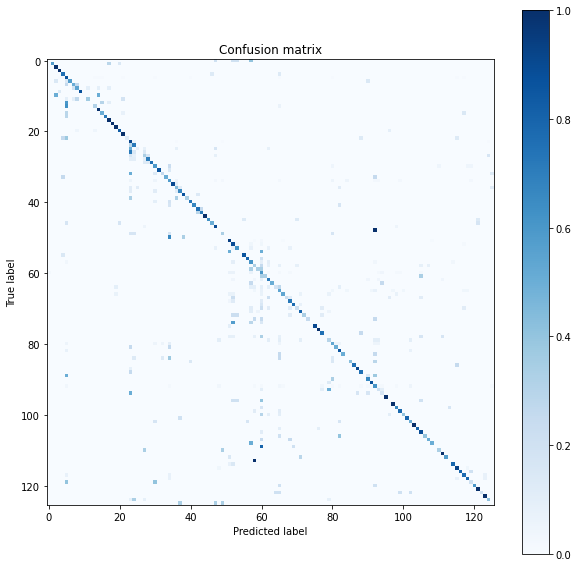

In [156]:
from sklearn.metrics import confusion_matrix
import itertools

confusionMatrix = confusion_matrix(labels, pred)

confusionMatrix = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(confusionMatrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


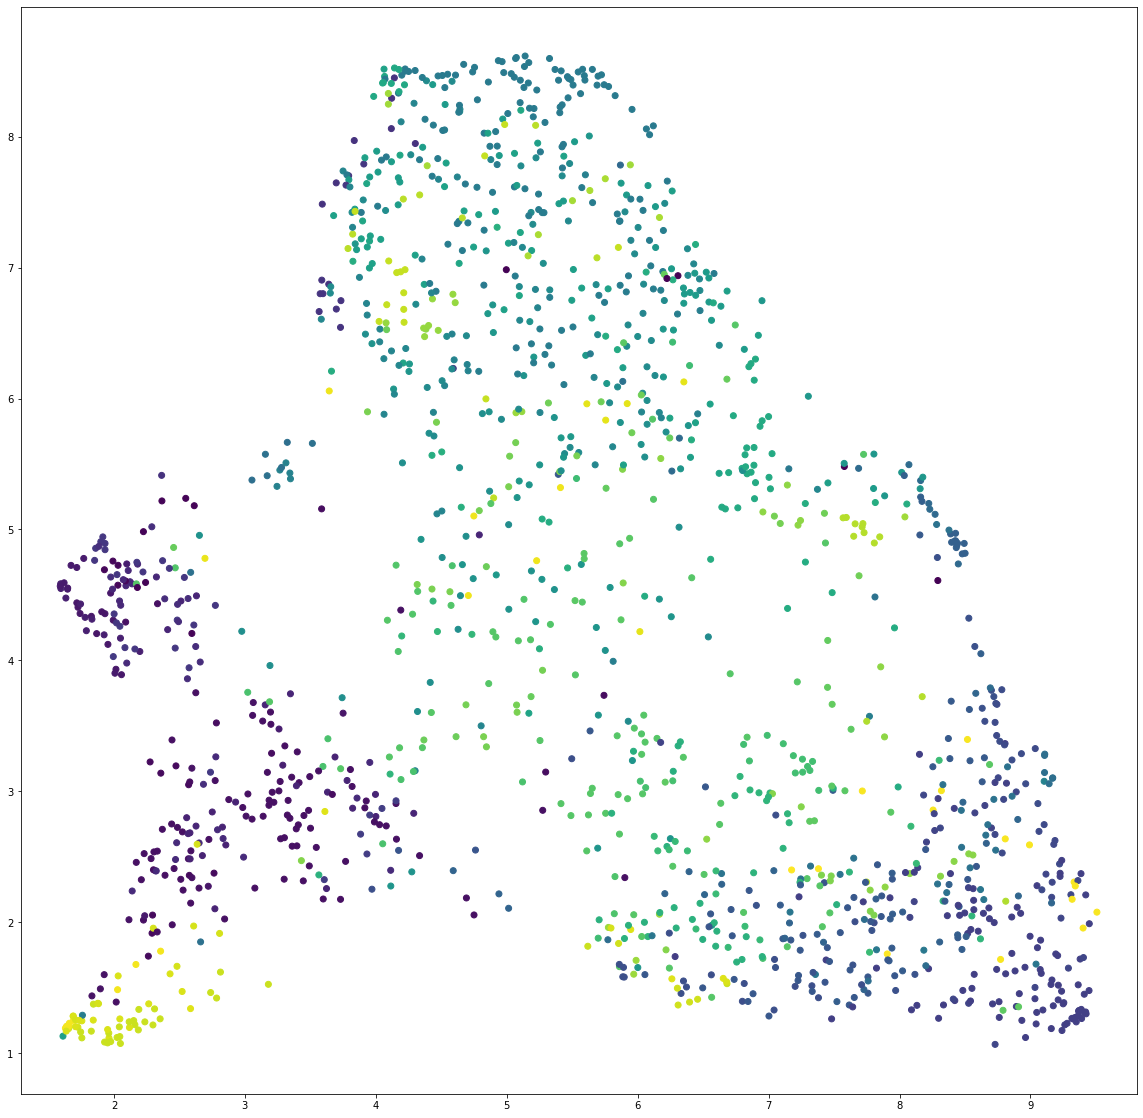

In [157]:
plt.figure(figsize=(20,20))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels)
plt.gca().set_aspect('equal', 'datalim')

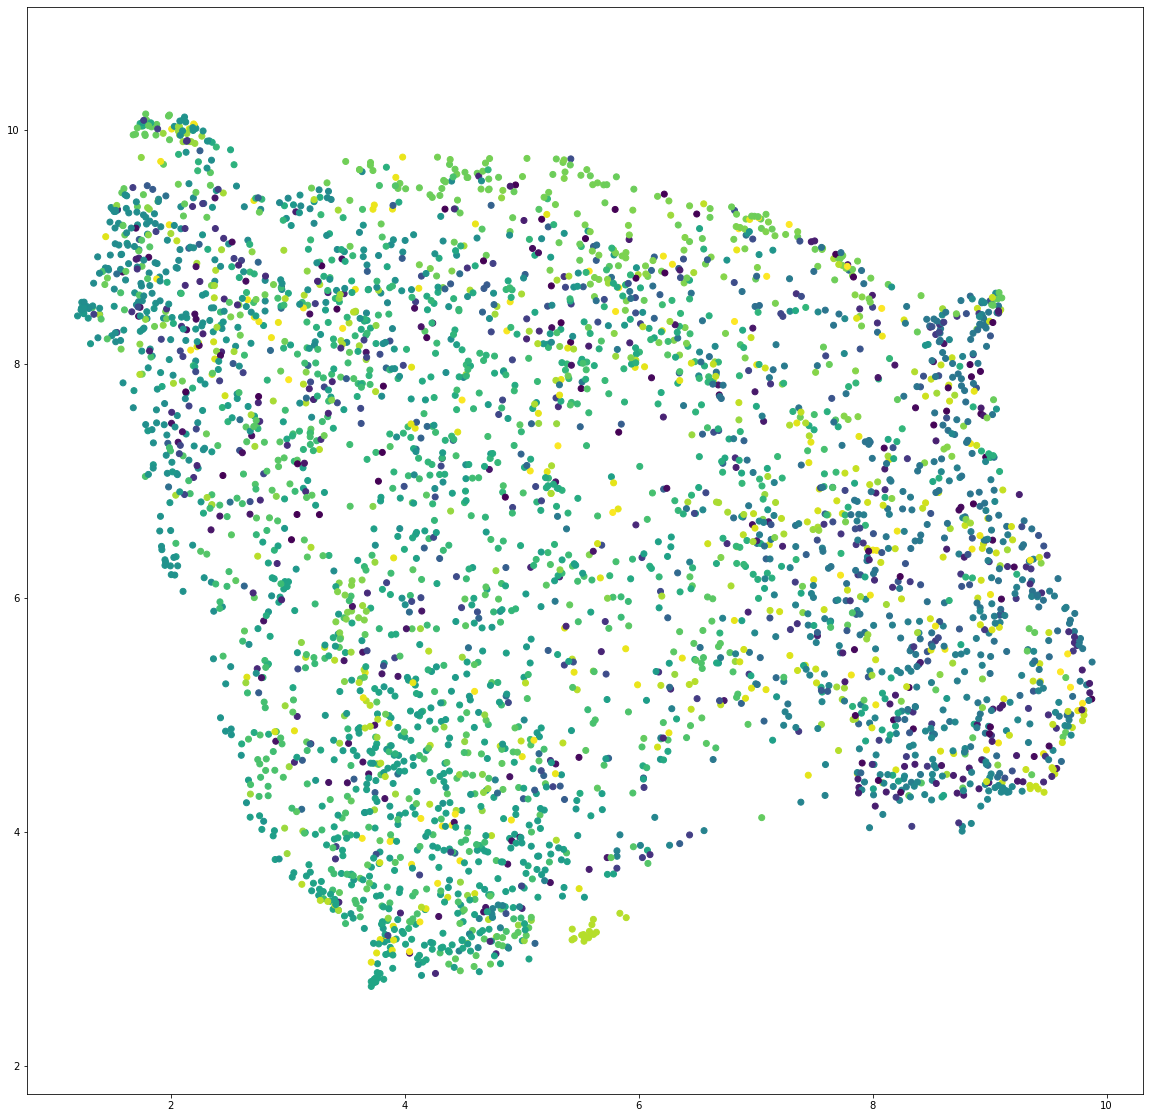

In [137]:
plt.figure(figsize=(20,20))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels)
plt.gca().set_aspect('equal', 'datalim')